# CSI 4142 - Introduction to Data Science
# Assignment 3: Predictive analysis Regression and Classification

Shacha Parker (300235525)\
Callum Frodsham and (300199446)\
Group 79

### Setup Instructions To Reproduce this Data Cleaning Notebook:
(Step 1 Optional)
1. Create a virtual python environment in the project directory (if you want) for all of the packages required:  
``` 
python -m venv .venv
```
To enter the virutal environment: 
```
.venv/Scripts/activate.ps1 # on windows
source .venv/bin/activate # on mac/linux
```
2. Download all of the required packages (run in cmd/shell of choice):
```
pip install jupyter
pip install ipykernel
pip install pandas
pip install numpy
```
3. VSCode: Ensure you have the correct python kernel selected!
<br> 
If you are using a virtual environment, make sure to select the python interpreter for that virtual environment otherwise this will not work! If you have everything done globally, then just make sure the correct python kernel you are using is selected.

<h1>Dataset 2: Breast Cancer</h1>
<h3>Decision Tree Classification</h3>

Author: Reihaneh Namdari
<br>
Purpose: The purpose of this dataset is to provide population-based cancer statistics on patients with infiltrating duct and lobular carcinoma breast cancer that were diagnosed in 2006-2010. 
<br>
Shape: This dataset is composed of 16 columns, and 4024 rows.
<br><br>
Link: <a href="https://www.kaggle.com/datasets/reihanenamdari/breast-cancer"> Breast Cancer Dataset</a>
<br>
Note: This description only includes 10/16 features, as the rest will not be used.\
The differentiate feature was removed because it is the same as the grade feature.\
The 6th Stage feature was removed because it can be derived by the n stage, t stage and grade features.

<h3>Dataset Feature List: </h3>
<ol>
    <li>Age:
    <br>
    Feature Type: Numerical - Discrete
    <br>
    Description: The age in years of the patient.
    </li>
    <br>
    <li>Race:
    <br>
    Feature Type: Categorical - Nominal
    <br>
    Description: The race of patient.
        </li>
    <br>
    <li>Marital Status:
    <br>
    Feature Type: Categorical - Nominal
    <br>
    Description: The marital status of the patient.
        </li>
    <br>
    <li>T Stage:
    <br>
    Feature Type: Categorical - Ordinal
    <br>
    Description: The T stage refers to the Tumor stage of the TNM staging system that describes the extent of the cancer such as tumor size, and tumor invasion into nearby structures. T1-T3 in increasing severity. 
        </li>
    <br>
    <li>N Stage:
    <br>
    Feature Type: Categorical - Ordinal
    <br>
    Description: N Stage refers to the Node stage of the TNM staging system that describes whether the cancer has spread to other nearby lymph nodes, with N1-N3 increasing in severity.
        </li>
    <br>
    <li>Grade:
    <br>
    Feature Type: Categorical - Ordinal
    <br>
    Description: The 4 grades, 1, 2, 3 and anaplastic Grade 4 describe the histologic grade of the cancer cells.
        </li>
    <br>
    <li>A Stage:
    <br>
    Feature Type: Categorical - Nominal
    <br>
    Description: Two categories, distant and regional. Distant means that the tumor has spread/metastasized to far away organs/regions from the original site. Regional implies that that the tumor has extended in areas close to the original site. 
        </li>
    <br>
    <li>Tumor Size:
    <br>
    Feature Type: Numerical - Continuous
    <br>
    Description: The size of the tumor in exact millimeters.
        </li>
    <br>
    <li>Survival Months:
    <br>
    Feature Type: Numerical - Continuous
    <br>
    Description: The length of time in months until the patients death or their last follow up.
        </li>
    <br>
    <li>Status:
    <br>
    Feature Type: Categorical - Nominal
    <br>
    Description: The status of the patient at their last follow up, with two categories, dead or alive.
        </li>
</ol>

In [137]:
# Initial Imports:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, cv
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import colormaps

# Then load the dataset
dataset = pd.read_csv("Breast_Cancer.csv")
# a list of excluded features to prevent the scope of this assignment from creeping. 
excluded_columns = ['Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive', 'differentiate', '6th Stage']
dataset = dataset.drop(columns=excluded_columns)

## Data Cleaning
The Data Cleaning step will identify whether the dataset has any incorrect or missing values.

In [138]:
# Display information about the dataframe
print(dataset.info())

# Describe the dataframe
print(dataset.describe())

# Check for missing values
missing_values = dataset.isnull().sum()
print("Missing values in each column:\n", missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              4024 non-null   int64 
 1   Race             4024 non-null   object
 2   Marital Status   4024 non-null   object
 3   T Stage          4024 non-null   object
 4   N Stage          4024 non-null   object
 5   Grade            4024 non-null   object
 6   A Stage          4024 non-null   object
 7   Tumor Size       4024 non-null   int64 
 8   Survival Months  4024 non-null   int64 
 9   Status           4024 non-null   object
dtypes: int64(3), object(7)
memory usage: 314.5+ KB
None
               Age   Tumor Size  Survival Months
count  4024.000000  4024.000000      4024.000000
mean     53.972167    30.473658        71.297962
std       8.963134    21.119696        22.921430
min      30.000000     1.000000         1.000000
25%      47.000000    16.000000        56.000000
50

As can be seen from the data above, the data contains no null values, and each feature has the correct value types.

In [139]:
# Checking for correct value range for each categorical feature:
categorical_columns_initial = dataset.select_dtypes(include=['object']).columns
for column in categorical_columns_initial:
    print(f"\nUnique values in column '{column}':\n", dataset[column].unique())


Unique values in column 'Race':
 ['White' 'Black' 'Other']

Unique values in column 'Marital Status':
 ['Married' 'Divorced' 'Single ' 'Widowed' 'Separated']

Unique values in column 'T Stage ':
 ['T1' 'T2' 'T3' 'T4']

Unique values in column 'N Stage':
 ['N1' 'N2' 'N3']

Unique values in column 'Grade':
 ['3' '2' '1' ' anaplastic; Grade IV']

Unique values in column 'A Stage':
 ['Regional' 'Distant']

Unique values in column 'Status':
 ['Alive' 'Dead']


As can be seen from the data above, each categorical feature has the values and there are no incorrect or missing values. Therefore it can be ascertained that the dataset is "clean".

## Data Splitting:
We're going to divide this dataset into a test set, DT, and the reduced training set D = D - DT.
We will then have 4 sets in total in the end:\
DR1 = DR\
DR2 = DR - outliers\
DR3 = DR + aggregation\
DR4 = (DR + aggregation) - outliers

In [140]:
# Lets create the test set, DT, we're going to divide the dataset in 80/20, and thus the 20 leftover will be the test set.
DR, DT = train_test_split(dataset, test_size=0.2, random_state=23)
# confirm they are the correct size
print(f"Number of rows in DR: {DR.shape[0]}")
print(f"Number of rows in DT: {DT.shape[0]}")
ratio = (DT.shape[0] / (DR.shape[0] + DT.shape[0]))
print(ratio)

Number of rows in DR: 3219
Number of rows in DT: 805
0.2000497017892644


## EDA and Outlier detection


### Categorical Feature Exploration:

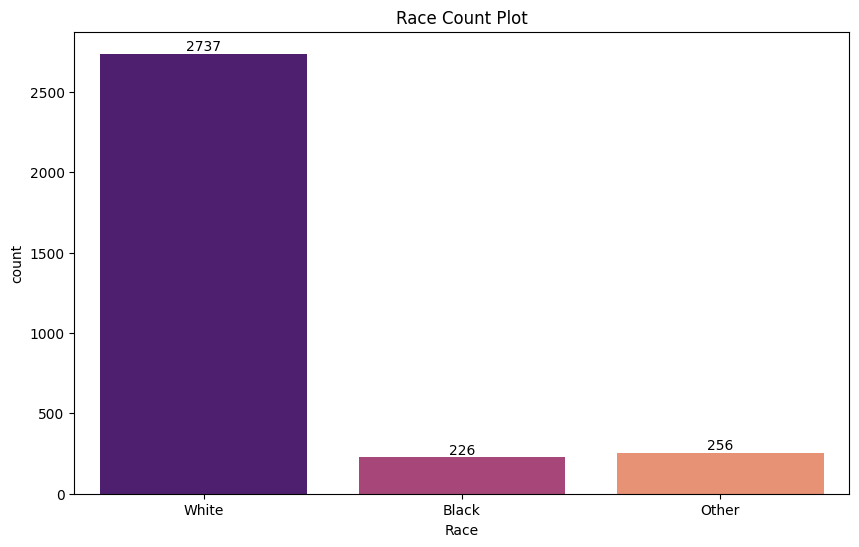

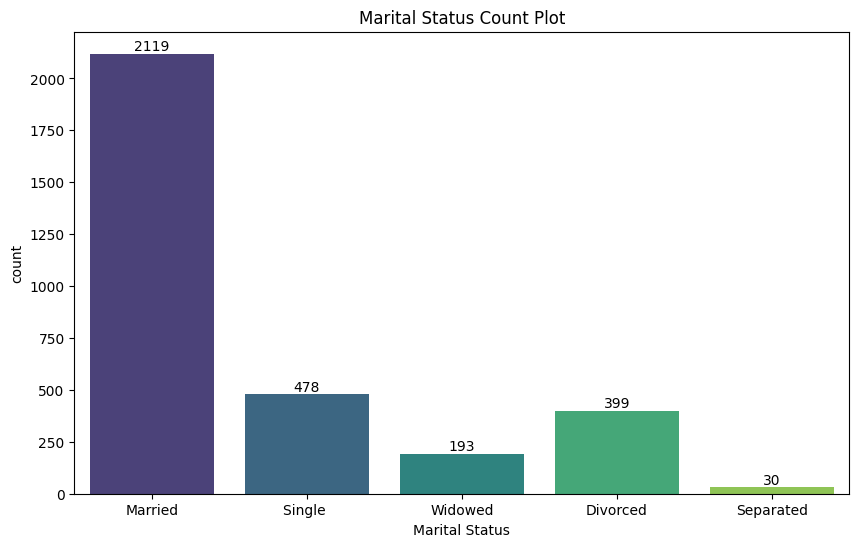

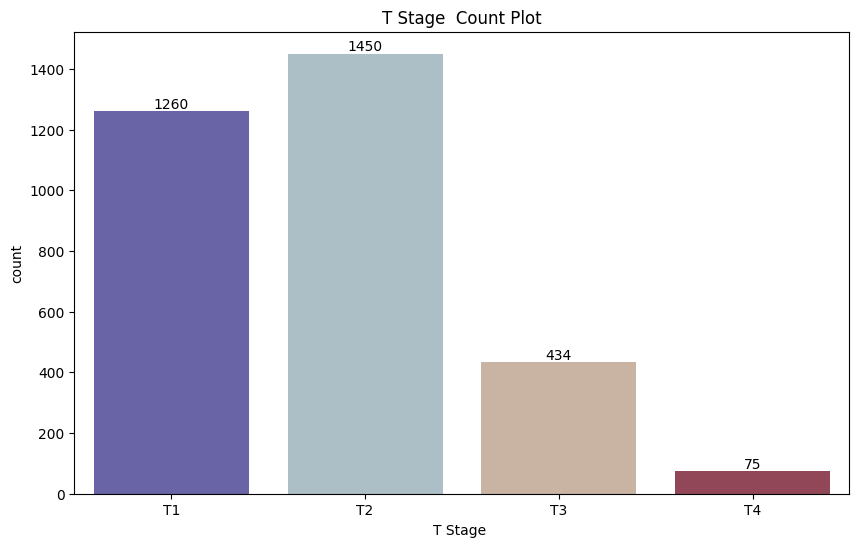

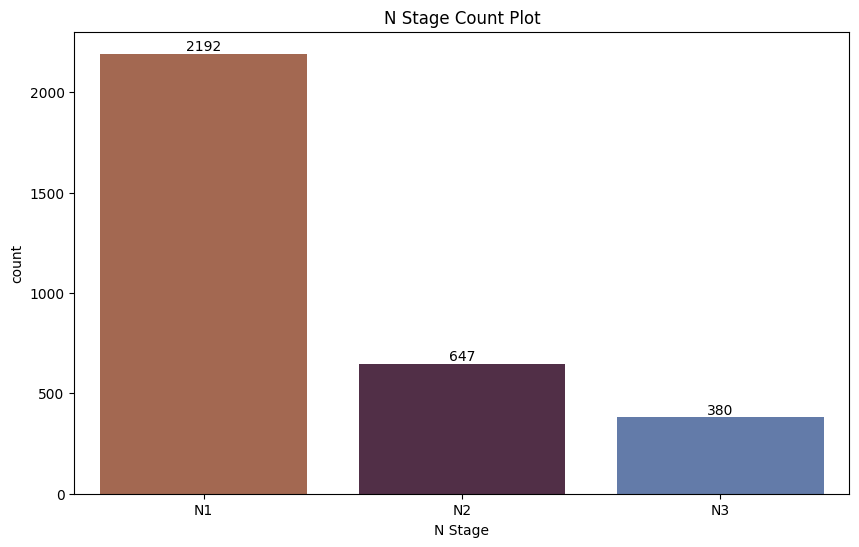

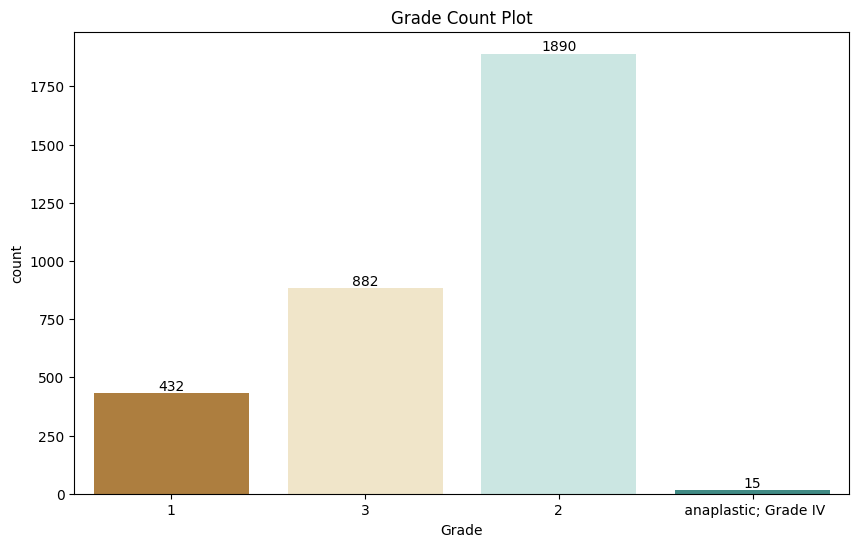

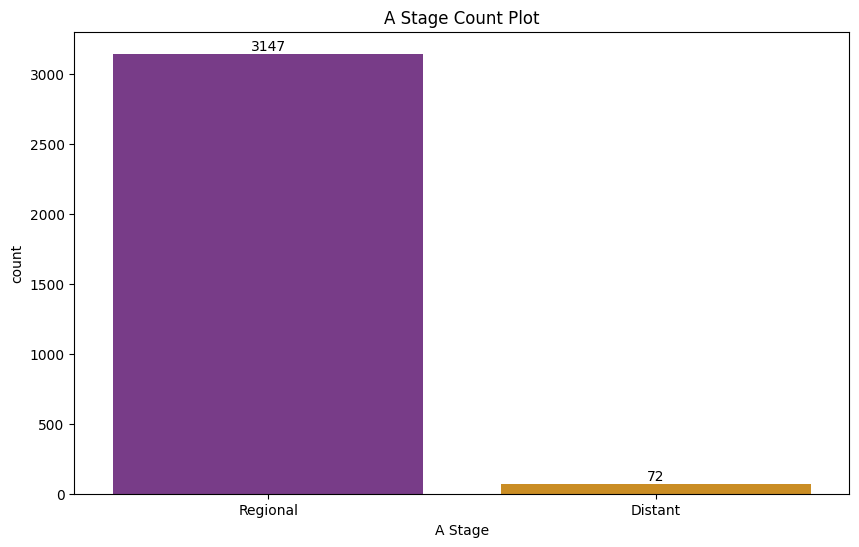

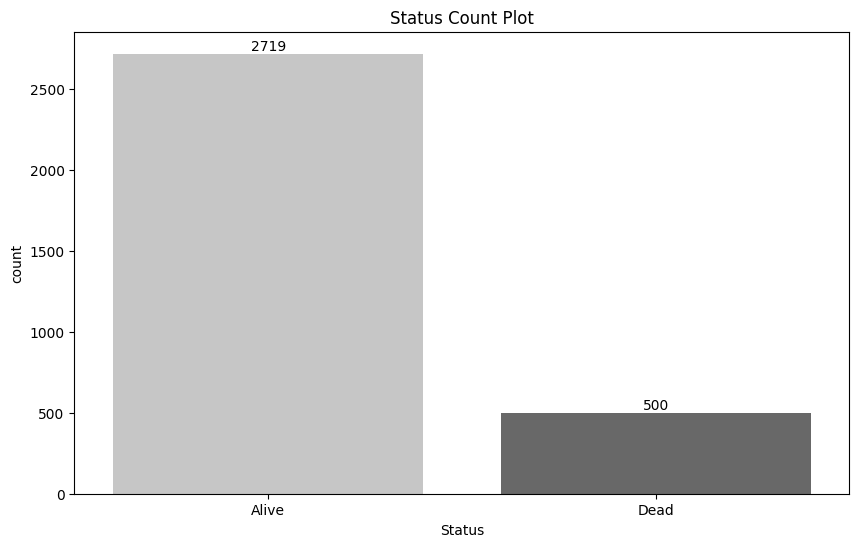

In [141]:
# Creating visualizations from the reduced training categorical columns:
new_categorical_columns = DR.select_dtypes(include=['object']).columns
color_list = list(colormaps)
count = 0;
for column in new_categorical_columns:
    plt.figure(figsize=(10, 6))
    graph = sns.countplot(data=DR, x=column, hue=column, palette=color_list[count])
    count += 3
    for bar in graph.containers:
        graph.bar_label(bar)
    plt.title(f"{column.title()} Count Plot")
    plt.show()


#### Handling Outliers for Categorical Features:

Most of the categorical features do not contain any outliers. The "Grade", and "A Stage" features have their own categories that are much rarer than the others. Those being, anaplastic, and distant. These rare categories will not be considered outliers as they are important, and could provide meaningful insight later on in the empirical study.

## EDA of Numerical Features and Outlier Detection:

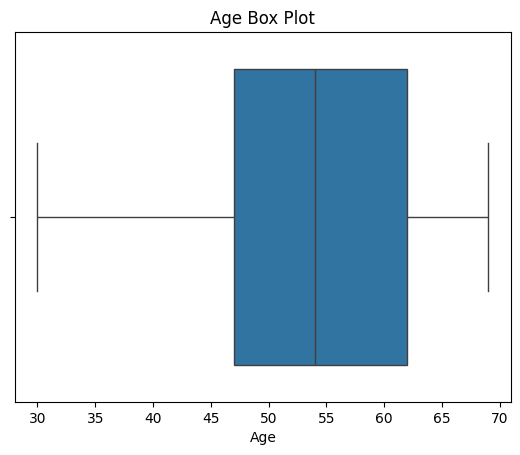

In [142]:
# get all of the numerical columns
numerical_data = DR.select_dtypes(include=['int64'])

# create a box plot of the age to view any possible outliers
sns.boxplot(data=DR, x='Age')
plt.title("Age Box Plot")
plt.show()

As can be seen from the Age Box plot above, there are no outliers in age.

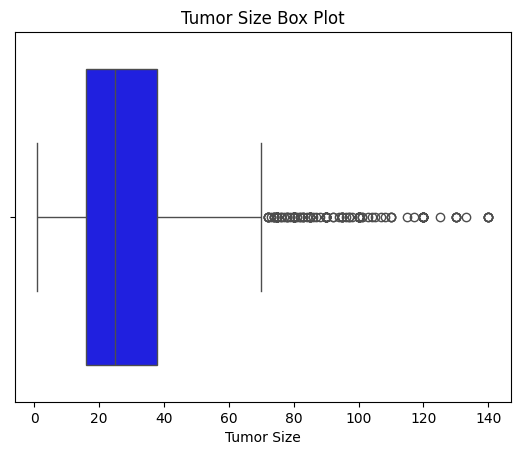

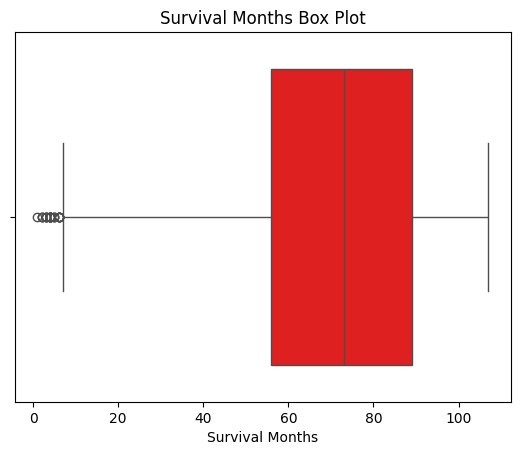

In [143]:
sns.boxplot(data=DR, x='Tumor Size', color='blue')
plt.title("Tumor Size Box Plot")
plt.show()

sns.boxplot(data=DR, x='Survival Months', color='red')
plt.title("Survival Months Box Plot")
plt.show()

In [144]:
# Calculating the IQR for both survival months, and the Tumor Size Features:

# calculate IQR for the tumor size
Q1TS = np.percentile(DR["Tumor Size"], 25)
Q3TS = np.percentile(DR["Tumor Size"], 75)
IQRTS = Q3TS - Q1TS 

# get upper bound
upper_bound = Q3TS + 1.5 * IQRTS
outliers_ts = DR[DR["Tumor Size"] > upper_bound]
percentile_of_upper_bound_ts = (DR["Tumor Size"] > upper_bound).mean() * 100
print("Tumor Size IQR info:")
print(f"Percentile of upper bound: {percentile_of_upper_bound_ts}%")
print(f"Number of outliers: {outliers_ts.shape[0]}")

# calculate IQR for the survival months
Q1SM = np.percentile(DR["Survival Months"], 25) 
Q3SM = np.percentile(DR["Survival Months"], 75) 
IQRSM = Q3SM - Q1SM

lower_bound_sm = Q1SM - 1.5 * IQRSM

# percentile rank of the lower bound of sm
outliers_sm = DR[(DR["Survival Months"] < lower_bound_sm)]
percentile_of_lower_bound_sm = (DR["Survival Months"] < lower_bound_sm).mean() * 100
print("Surival Months IQR info:")
print(f"Percentile of lower bound: {percentile_of_lower_bound_sm}%")
num_rows_sm = outliers_sm.shape[0]
print(f"Number of outliers: {num_rows_sm}")


Tumor Size IQR info:
Percentile of upper bound: 5.467536502019261%
Number of outliers: 176
Surival Months IQR info:
Percentile of lower bound: 0.8387698042870456%
Number of outliers: 27


As can be seen, both features contain outliers. The Survival months feature has outliers in the 0.83% percentile containing 27 values, and the tumor size box plot shows that there are 176 outliers contained in the upper 5.467% percentile. However, this was just to show that there are outliers that need to be handled. We will find the outliers we want to remove with LOF, by comparing both the Tumor Size and the Survival Months feature.

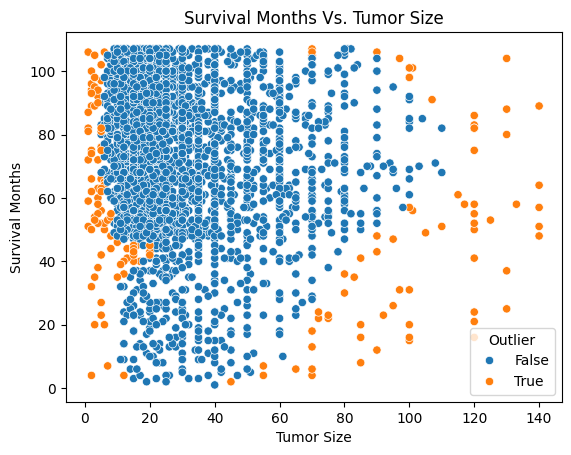

In [145]:
# first get the features we want to apply LOF outlier removal to:
tumor_and_months_df = DR[['Tumor Size', 'Survival Months']].copy()
# get the LOF of these two features
lof_labels = LocalOutlierFactor(n_neighbors=50, contamination= 0.05).fit_predict(tumor_and_months_df)

# modify the new df we created
tumor_and_months_df["LOF_Score"] = lof_labels
tumor_and_months_df["LOF_outlier_val"] = tumor_and_months_df["LOF_Score"] == -1


sns.scatterplot(data=tumor_and_months_df, x='Tumor Size', y ='Survival Months', hue="LOF_outlier_val")
plt.legend(title="Outlier")
plt.title("Survival Months Vs. Tumor Size")
plt.show()

# removal of outliers using LOF
#tumor_and_months_df_clean = tumor_and_months_df[tumor_and_months_df["LOF_Anomaly"] == False]

# create a copy of the dataset to remove the outliers
DR2 = DR.copy()

DR2["LOF_outlier_val"] = tumor_and_months_df["LOF_outlier_val"]
# remove the values
DR2 = DR2[DR2["LOF_outlier_val"] == False]




This graph highlights the outliers found by LOF in orange. LOF parameters are n = 50, and the contamination percentage set to 3.5%. We will deal with these outliers by removing them, and this will be shown later in the empirical study portion of this notebook. 

#### Handling Outliers:

1. For the comparison of Tumor Size and Survival Months, the outliers found using LOF (as above) will be removed.  
2. The Marital Status feature's outlier category, separated, will be combined into the Divorced category.

We will expand on these methods of handling the outliers further into the empirical study when the different test/validation sets are created.

## Predictive Analysis: Decision Trees
I will be using catboost's decision tree classification methods, instead of scikit's due to catboost's ability to natively process categorical features without any encoding.\
I aim to classify tumor A Stage using the Decision Tree model trained on patient features.\
Catboost's DecisionTreeClassifier does not have the same parameters as scikit's. Thus, I will be choosing my own parameters for catboost's model.\
I will be employing the 'MultiClass' loss function.\
The model will iterate 650 times.

## Feature Engineering

First Feature: Tumor Size to T Stage ratio
Second Feature: Tumor Size to N Stage Ratio

In [146]:
# create a copy of DR1 (DR) to add the aggregated features to:
DR3 = DR.copy()

# First feature: Tumor Size to T Stage
t_stage_map = {'T3':3, 'T2':2, 'T1':1,'T4':4}

# modify the dataset to add the fixed t stage map
DR3["TNumber"] = DR3["T Stage "].map(t_stage_map)

# then add the new feature:
DR3['SizeToTStageRatio'] = DR3['TNumber'] / DR3['Tumor Size']


# Second Feature: N Stage to Tumor size ratio

n_stage_map = {'N1':1, 'N2':2, 'N3':3}
DR3['NNumber'] = DR3['N Stage'].map(n_stage_map)

DR3['SizeToNStageRatio'] = DR3['NNumber'] / DR3['Tumor Size'] 

# remove the intermediary columns.
DR3.drop(columns=['NNumber','TNumber'], inplace=True)

Lets create the final Dataset copy, DR4 which will include the aggregations, without the outlier values we found above.

In [147]:
# we have DR4 which is (DR + aggregation) - outliers
DR4 = DR3.copy()

# now we need to remove the outliers
DR4["LOF_outlier_val"] = tumor_and_months_df["LOF_outlier_val"]
DR4 = DR4[DR4["LOF_outlier_val"] == False]


## Empirical Study: Decision Tree Classification

Since we have all 4 versions of the dataset, DR1, DR2, DR3, and DR4
we can proceed with 4 cross fold validation and training the decision trees. 

### DR1:
Where DR1 is the base dataset with the test set removed.

In [148]:
# setup the parameters for the catboost model
model_parameters = {
    'iterations' : 700,
    'depth': 7,
    'learning_rate': 0.01,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
}

dataset_accuracies = {}

# Beginning with DR1, get the independent and dependent vars to train for.
x_train_DR1 = DR.drop(columns=['Grade'])
y_train_DR1 = DR['Grade']

# get the names of all categorical features for the model:
# except for the grade which we are training for
cat_features = ['Race', 'Marital Status', 'T Stage ', 'N Stage', 'A Stage', 'Status']

# convert the data into catboosts optimized formatting
train_pool = Pool(x_train_DR1, label=y_train_DR1, cat_features=cat_features)


# results of evaluation
cross_validation_results = cv(train_pool, model_parameters, fold_count=4, partition_random_seed=23, verbose =False)

# get the best results for each fold:
fold_accuracy_vals = cross_validation_results['test-Accuracy-mean']
highest_per_fold = fold_accuracy_vals.max()

# add it to the accuracies for DR1
dataset_accuracies['DR1'] = highest_per_fold

print(dataset_accuracies)

Training on fold [0/4]
bestTest = 0.58808933
bestIteration = 28
Training on fold [1/4]
bestTest = 0.6066997519
bestIteration = 32
Training on fold [2/4]
bestTest = 0.5932835821
bestIteration = 91
Training on fold [3/4]
bestTest = 0.6102117061
bestIteration = 309
{'DR1': 0.595223644069945}


### DR2: 
Where DR2 is DR1 with outliers removed.

In [149]:
# get the independent and dependent vars to train for.
x_train_DR2 = DR2.drop(columns=['Grade'])
y_train_DR2 = DR2['Grade']


# convert the data into catboosts optimized formatting
train_pool = Pool(x_train_DR2, label=y_train_DR2, cat_features=cat_features)


# results of evaluation
cross_validation_results = cv(train_pool, model_parameters, fold_count=4, partition_random_seed=23, verbose =False)

# get the best results for each fold:
fold_accuracy_vals = cross_validation_results['test-Accuracy-mean']
highest_per_fold = fold_accuracy_vals.max()

# add it to the accuracies for DR2
dataset_accuracies['DR2'] = highest_per_fold
print(dataset_accuracies)

Training on fold [0/4]
bestTest = 0.6010430248
bestIteration = 55
Training on fold [1/4]
bestTest = 0.5830065359
bestIteration = 46
Training on fold [2/4]
bestTest = 0.5910878113
bestIteration = 24
Training on fold [3/4]
bestTest = 0.5989515072
bestIteration = 266
{'DR1': 0.595223644069945, 'DR2': 0.5899240131762747}


### DR3:
Where DR3 is the dataset with the added aggregations. 

In [150]:
# get the independent and dependent vars to train for.
x_train_DR3 = DR3.drop(columns=['Grade'])
y_train_DR3 = DR3['Grade']


# convert the data into catboosts optimized formatting
train_pool = Pool(x_train_DR3, label=y_train_DR3, cat_features=cat_features)

# results of evaluation
cross_validation_results = cv(train_pool, model_parameters, fold_count=4, partition_random_seed=23, verbose =False)

# get the best results for each fold:
fold_accuracy_vals = cross_validation_results['test-Accuracy-mean']
highest_per_fold = fold_accuracy_vals.max()

# add it to the accuracies for DR2
dataset_accuracies['DR3'] = highest_per_fold
print(dataset_accuracies)

Training on fold [0/4]
bestTest = 0.5905707196
bestIteration = 32
Training on fold [1/4]
bestTest = 0.6054590571
bestIteration = 6
Training on fold [2/4]
bestTest = 0.5957711443
bestIteration = 21
Training on fold [3/4]
bestTest = 0.6064757161
bestIteration = 95
{'DR1': 0.595223644069945, 'DR2': 0.5899240131762747, 'DR3': 0.5961506829790246}


### DR4:
Where DR4 is the dataset with aggregations added and outliers removed.

In [151]:
# get the independent and dependent vars to train for.
x_train_DR4 = DR4.drop(columns=['Grade'])
y_train_DR4 = DR4['Grade']


# convert the data into catboosts optimized formatting
train_pool = Pool(x_train_DR4, label=y_train_DR4, cat_features=cat_features)

# results of evaluation
cross_validation_results = cv(train_pool, model_parameters, fold_count=4, partition_random_seed=23, verbose =False)

# get the best results for each fold:
fold_accuracy_vals = cross_validation_results['test-Accuracy-mean']
highest_per_fold = fold_accuracy_vals.max()

# add it to the accuracies for DR2
dataset_accuracies['DR4'] = highest_per_fold
print(dataset_accuracies)

Training on fold [0/4]
bestTest = 0.5984354628
bestIteration = 2
Training on fold [1/4]
bestTest = 0.5843137255
bestIteration = 268
Training on fold [2/4]
bestTest = 0.6015727392
bestIteration = 416
Training on fold [3/4]
bestTest = 0.5976408912
bestIteration = 43
{'DR1': 0.595223644069945, 'DR2': 0.5899240131762747, 'DR3': 0.5961506829790246, 'DR4': 0.5922244172479705}


## Final System Decision:
Based on the values from the empirical study, the DR3 dataset seems to provide highest average accuracy, and thus will be used to perform the final evaluation.

In [152]:
# We need to modify the test set by adding the aggregations.

# add the aggregation features to the training dataset
DT["TNumber"] = DT["T Stage "].map(t_stage_map)

DT['SizeToTStageRatio'] = DT['TNumber'] / DT['Tumor Size']

# Second Feature: N Stage to Tumor size ratio

DT['NNumber'] = DT['N Stage'].map(n_stage_map)

DT['SizeToNStageRatio'] = DT['NNumber'] / DT['Tumor Size'] 

#remove the intermediary columns
# and remove the Grade since that is what we are predicting?
DT.drop(columns=['NNumber','TNumber'], inplace=True)

# Perform the final test:
final_model = CatBoostClassifier(
    iterations=700,
    depth=7,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    task_type='GPU',
    verbose=False
)

# train the model
final_model.fit(x_train_DR3, y_train_DR3, cat_features=cat_features)

# split up our data
y_test_DT = DT['Grade']
x_test_DT = DT.drop(columns=['Grade'])

# get our predictions for the grade
y_prediction = final_model.predict(x_test_DT)

test_set_accuracy_score = accuracy_score(y_test_DT, y_prediction)

print(test_set_accuracy_score)


0.5515527950310559


## Result Analysis:
The mean accuracy results for DR1-DR4 are: 59.522%, 58.992%, 59.615%, 59.222%. Unforunately, there were very small differences between the accuracy results of the 4-fold cross validation training/testing. There are very small decreases when removing the outliers. This indicates that my choices for outlier removal were incorrect, and the process needs to be fine tuned. There was a very slight increase in the results when adding the aggregated features, but the increase was less than 0.1 percent, which is very miniscule. There was an approximate 4% difference between the results from the final test on the test set and the result from the DR3 4-fold cross validation. This is a small decrease but is within normal means. 

## References:
<ul>
<li>
<a href="https://catboost.ai/docs/en/concepts/python-usages-examples">CatBoostClassifier Docs</a>
</li>
<li>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html">Sci Kit LOF Docs</a>
</li>
<li>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html">Sci Kit Accuracy Score</a>
</li>
</ul>